In [1]:
import geopandas as gpd
import folium
import gc
import os
from PIL import Image
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import numpy as np
import os
#from geojson import Point
from geojson import Polygon
import geojson
import tempfile
import datetime as dt
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio import plot
import rasterio.mask
import fiona
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage import exposure
import cv2

In [2]:
os.getcwd()

'C:\\Users\\X409\\Desktop\\project\\pythonProject'

In [3]:
#import bands as separate 1 band raster
imagePath = 'C:/Users/X409/Desktop/project/pythonProject/data/S2A_MSIL1C_20210206T095201_N0209_R079_T33SVV_20210206T110416.SAFE/GRANULE/L1C_T33SVV_A029391_20210206T095357/IMG_DATA/'
band2 = rasterio.open(imagePath+'T33SVV_20210206T095201_B02.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open(imagePath+'T33SVV_20210206T095201_B03.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open(imagePath+'T33SVV_20210206T095201_B04.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open(imagePath+'T33SVV_20210206T095201_B08.jp2', driver='JP2OpenJPEG') #nir
#number of raster bands
print(band4.count)
#number of raster columns
print(band4.width)
#number of raster rows
print(band4.height)

#type of raster byte
print(band4.dtypes[0])
#raster sytem of reference
print(band4.crs)
#raster transform parameters
print(band4.transform)
#raster values as matrix array
#band4.read(1)

1
10980
10980
uint16
EPSG:32633
| 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


Note the very large amount of pixels, data type and CRS (Coordinate Reference System): EPSG 32633 with WGS84 datum
Read: https://epsg.io/32633

In [4]:
# Read the grid values into numpy arrays
red = band4.read(1)
green = band3.read(1)
blue = band2.read(1)


# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.010742677231258638
0.0 - 1.0 mean: 0.021219159292261355
0.0 - 1.0 mean: 0.0318399665340799


Note the very low mean in the values above.

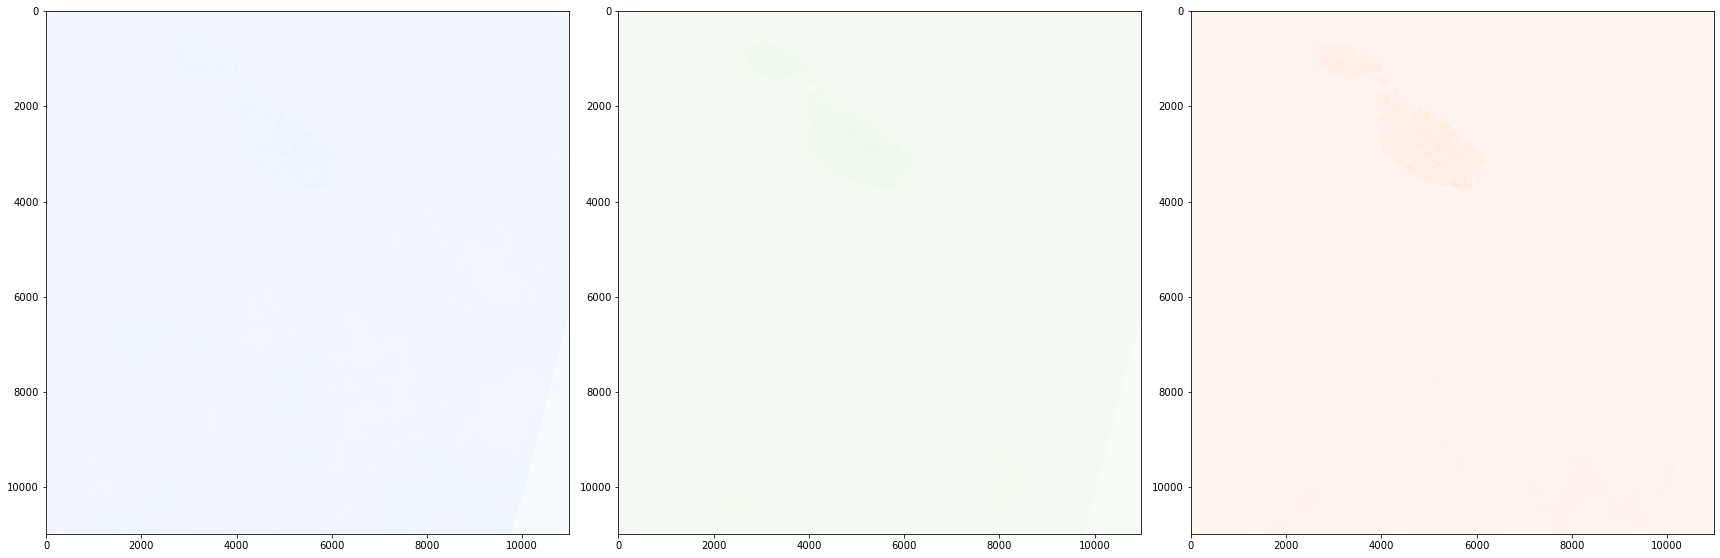

In [5]:
#multiple band representation using NUMPY

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
plot.show(bluen, ax=ax1, cmap='Blues')
plot.show(greenn , ax=ax2, cmap='Greens')
plot.show(redn, ax=ax3, cmap='Reds')
fig.tight_layout()

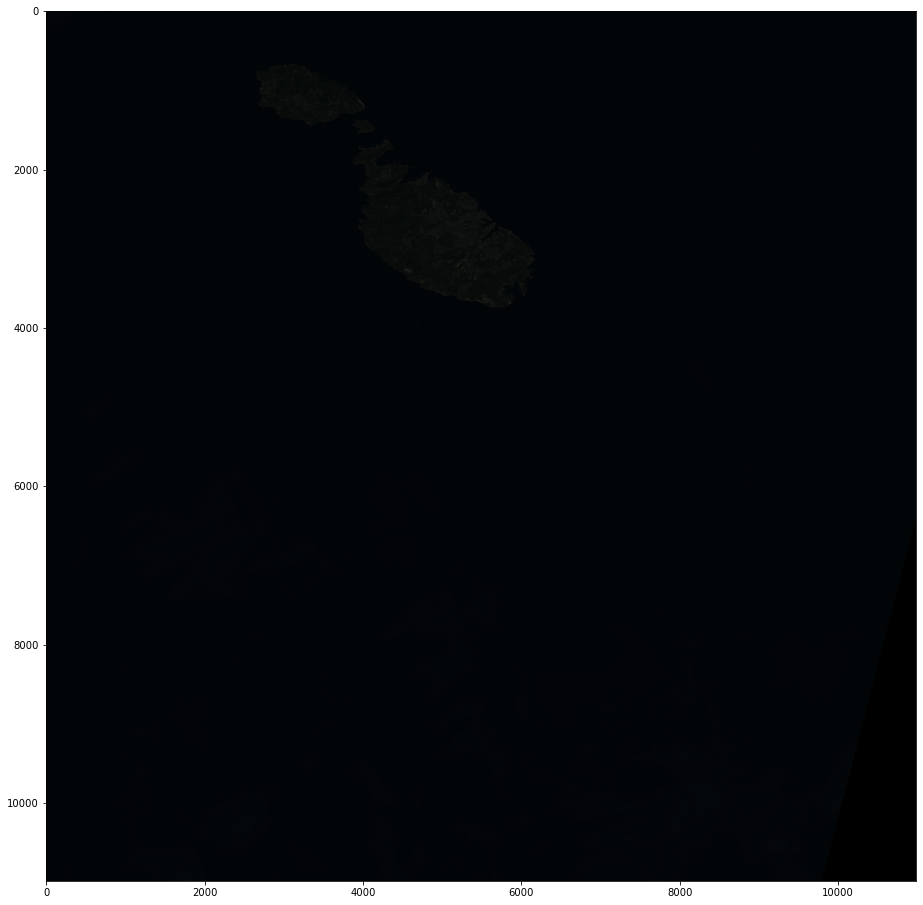

2332

In [6]:
#Stack to recompose RGB

rgb = np.dstack((redn,greenn,bluen))
plt.figure(figsize=(20,16))
plt.imshow(rgb)
plt.show()
gc.collect()

#Note the processing time and dark display due to high number normalized radiance values

In [7]:
#export true color image
trueColor = rasterio.open('C:/Users/X409/Desktop/project/pythonProject/Output/SentinelTrueColor5.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),1) #Blue
trueColor.write(band3.read(1),2) #Green
trueColor.write(band4.read(1),3) #Red
trueColor.close()


In [8]:
#export false color image
falseColor = rasterio.open('C:/Users/X409/Desktop/project/pythonProject/Output//SentinelFalseColor4.tiff', 'w', driver='Gtiff',
                          width=band2.width, height=band2.height,
                          count=3,
                          crs=band4.crs,
                          transform=band2.transform,
                          dtype='uint16'
                         )
falseColor.write(band8.read(1),1) #Near Infrared
falseColor.write(band4.read(1),2) #Red
falseColor.write(band3.read(1),3) #Green


falseColor.close()

Values in Sentinel products are in radiance. Note the range of values in red, green, blue arrays. For correct visualisation we need
to convert into reflectance. For an explanation of radiance and reflectance:

https://www.l3harrisgeospatial.com/Support/Self-Help-Tools/Help-Articles/Help-Articles-Detail/ArtMID/10220/ArticleID/19247/3377#:~:text=Radiance%20is%20the%20variable%20directly,from%20the%20object%20being%20observed.&text=Reflectance%20is%20the%20ratio%20of,It%20has%20no%20units



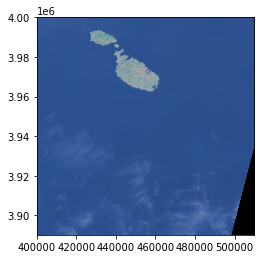

In [9]:
# Plot an intensity rescaled the RGB image with Rasterio

img = rasterio.open(r"C:/Users/X409/Desktop/project/pythonProject/Output/SentinelTrueColor5.tiff", count=3)

# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

plot.show(image.transpose(2,0,1), transform=img.transform)

6744

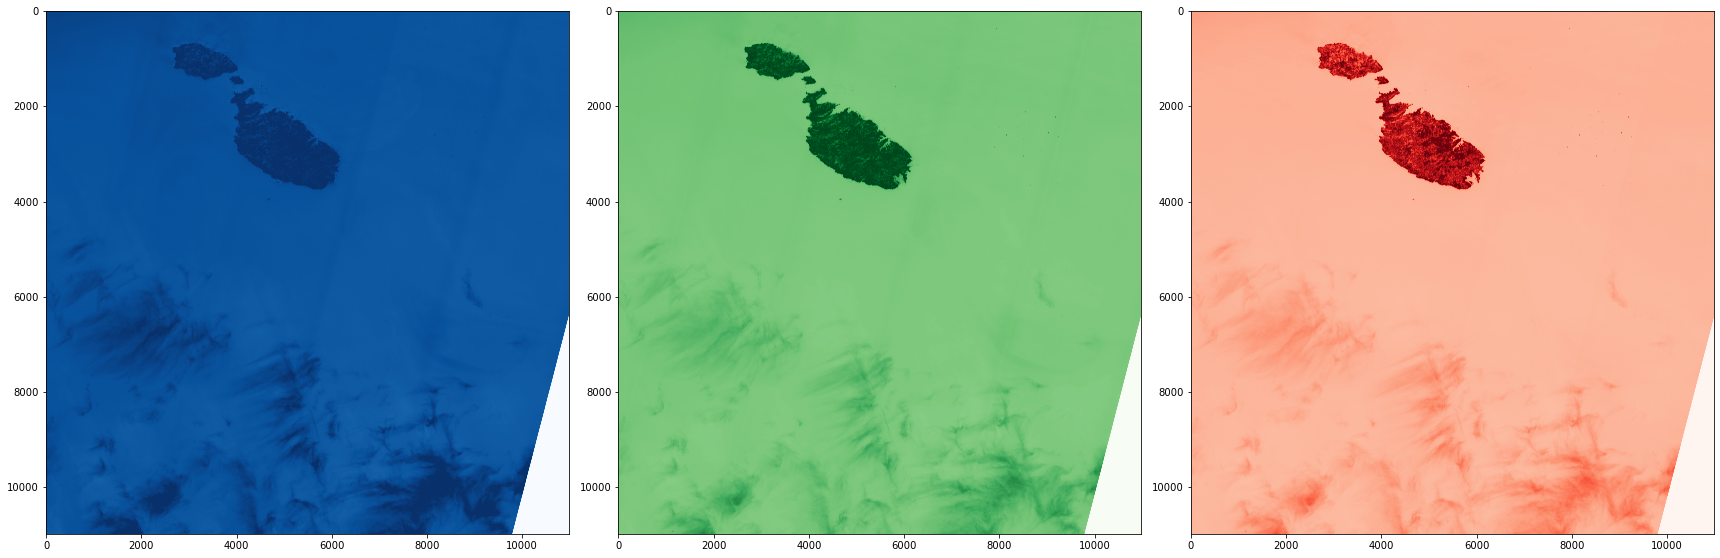

In [10]:
#multiple band representation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
plot.show(image[:,:,2], ax=ax1, cmap='Blues')
plot.show(image[:,:,1], ax=ax2, cmap='Greens')
plot.show(image[:,:,0], ax=ax3, cmap='Reds')
fig.tight_layout()
gc.collect()


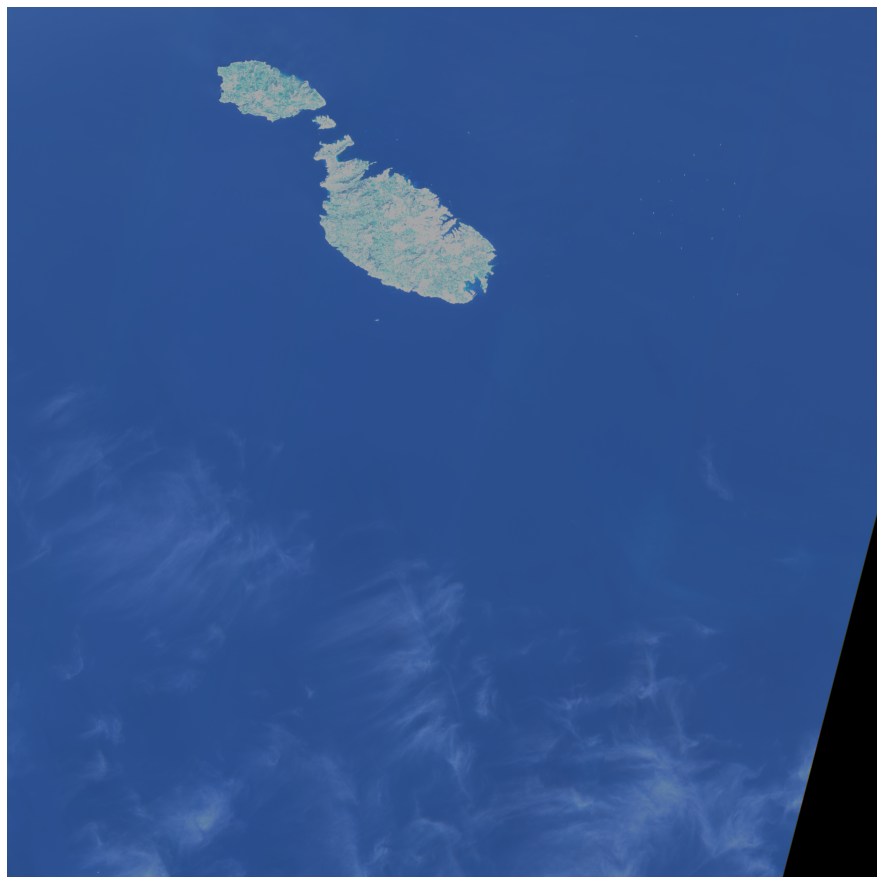

In [11]:
#Plot and save image with Matplotlib
fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(image)

#Save scaled reflectance image
# Call 'savefig' to save this plot to an image file
plt.savefig("C:/Users/X409/Desktop/project/pythonProject/Output/Sentinel_Scaled_Reflectance3.tiff", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()



C:\anaconda\envs\remsen\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


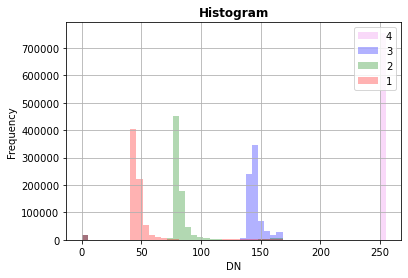

In [12]:
#generate histogram
trueColor = rasterio.open('C:/Users/X409/Desktop/project/pythonProject/Output/Sentinel_Scaled_Reflectance3.tiff')
plot.show_hist(trueColor, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")


Importing a ROI GeoJson vector file and masking your Sentinel image using the loaded ROI:

In [13]:
# Mask area of study

# Load polygon vector of Gozo to clip satellite image
boundsdata = r'C:/Users/X409/Desktop/project/pythonProject/data/Chadwick.geojson'
region = gpd.read_file(boundsdata)
region

,id,geometry
0,3,"MULTIPOLYGON (((14.37243 35.89399, 14.37243 35..."


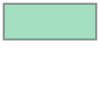

In [14]:
# Show footprint
footprint = None
for i in region['geometry']:
    footprint = i
footprint

In [15]:
#View on a folium map

m = folium.Map(location=[35.9452,14.3797], zoom_start=10)

folium.GeoJson(footprint).add_to(m)
m

C:\anaconda\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


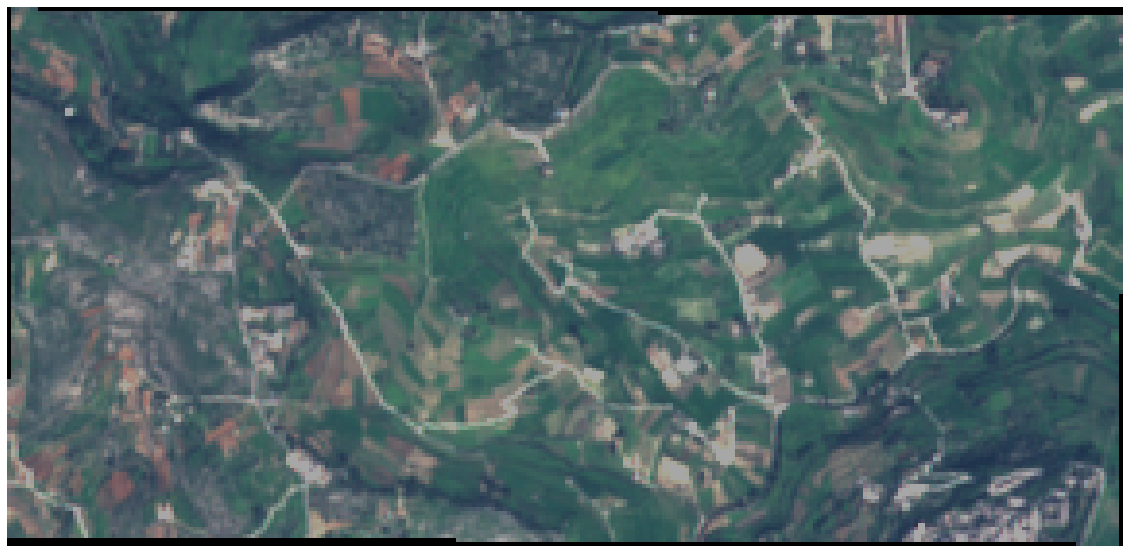

In [16]:
from PIL import Image

nReserve_proj = region.to_crs({'init': 'epsg:32633'})

with rio.open("C:/Users/X409/Desktop/project/pythonProject/Output/SentinelTrueColor5.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "dtype": "uint16"})



with rasterio.open("C:/Users/X409/Desktop/project/pythonProject/Output/RGB_masked3.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = np.array(out_image[[2,1,0], :, :])
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

rgb = np.array(image.transpose(1,2,0))

#Plot and save image with Matplotlib
fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(rgb)


rgbuint8 = cv2.normalize(rgb, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
bgr = cv2.cvtColor(rgbuint8, cv2.COLOR_RGB2BGR)
cv2.imwrite("C:/Users/X409/Desktop/project/pythonProject/Output/PROCESSED/Qlejgha4.png", bgr)
#Save scaled reflectance image
# Call 'savefig' to save this plot to an image file
#plt.savefig("../Output/PROCESSED/Gozo.png")
plt.show()


In [17]:
# short version to convert to GTiff

# Open Bands 4, 3 and 2 with Rasterio
#R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'
#b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
#b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
#b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')


# Create an RGB image
#with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height,
#              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
#    rgb.write(b2.read(1),1)
#    rgb.write(b3.read(1),2)
#    rgb.write(b4.read(1),3)
#    rgb.close()





